In [ ]:
from generate_data import *
from utils import *
import numpy as np
import cvxpy as cp
import warnings
warnings.filterwarnings("ignore")

global k, vk

In [18]:
Ts = 0.1

N = 10
Nu = 6
Lambda = 5e-2

# 1 - population, 2 - tracking, 3 - hiv
process = 3

In [ ]:
y_zad, fun, x, u, bds, model = initialize(process, N, Nu, Ts)
model.print(precision=int(3 - np.log10(Ts)))

y_zad_N = np.vstack([y_zad, np.tile(y_zad[-1], (N, 1))])
kmax, vk = len(y_zad), 0

(x1)[k+1] = 0.1000 1 + 0.9900 x1[k] + -0.1000 x1[k] x2[k] + 0.0980 x1[k] x2[k] u[k]
(x2)[k+1] = 0.9800 x2[k] + 0.1000 x1[k] x2[k] + -0.1000 x2[k] x4[k] + -0.1000 x2[k] x5[k] + -0.0980 x1[k] x2[k] u[k]
(x3)[k+1] = 0.9990 x3[k] + -0.0030 x2[k] x3[k] + 0.0060 x1[k] x2[k] x3[k]
(x4)[k+1] = 0.9900 x4[k] + 0.0030 x2[k] x4[k]
(x5)[k+1] = 0.9900 x5[k] + 0.0030 x2[k] x3[k]


In [20]:
def mpc_npl(model, state_est, u_prev, w=1):
    nx, nu = len(state_est), 1

    A, B = linearize(model, state_est, u_prev)

    P = np.zeros((nx*N, nu*Nu))
    xo = np.zeros((N, nx))

    for i in range(N):
        for j in range(min(i+1, Nu)):
            if i == j:
                P[nx*i:nx*(i+1), nu*j:nu*(j+1)] = B
            else:
                P[nx*i:nx*(i+1), nu*j:nu*(j+1)] = A_sum(A, i-j) @ B
        if i == 0:
            xo[i, :] = model.simulate(state_est, t=2, u=np.array([u_prev]))[-1] + vk
        else:
            xo[i, :] = model.simulate(xo[i-1,:], t=2, u=np.array([u_prev]))[-1] + vk

    C = np.eye(nx)
    C_bar = np.kron(np.eye(N), C)
    wx0 = (w * xo).reshape(-1, 1)
    y0 = C_bar @ wx0
    Yref = (w * y_zad_N[k] * np.ones((N, 1))).reshape(-1, 1)

    du = cp.Variable((nu*Nu, 1))
    cost = cp.sum_squares(Yref - C_bar @ P @ du - y0) + Lambda * cp.sum_squares(du)

    prob = cp.Problem(cp.Minimize(cost), constraints=[du >= -bds, du <= bds])
    prob.solve()

    return du.value[0, 0]

In [21]:
state = x[0]
w = [0, 1, 0, 0, 0]

for k in range(5, kmax):
    xmod = model.simulate(state, t=2, u=np.array([u[k-1]]))[-1]
    state = fun(t=0, state=state, T=Ts, u=u[k-1])

    x[k, :] = state

    try:
        du = mpc_npl(model, state, u[k-1], w)
    except Exception as e:
        print(f"NPL failed at step {k}: {e}")
        du = 0

    u[k] = u[k-1] + du
    # u[k] = np.clip(u[k], -10, 10)
    vk = state - xmod

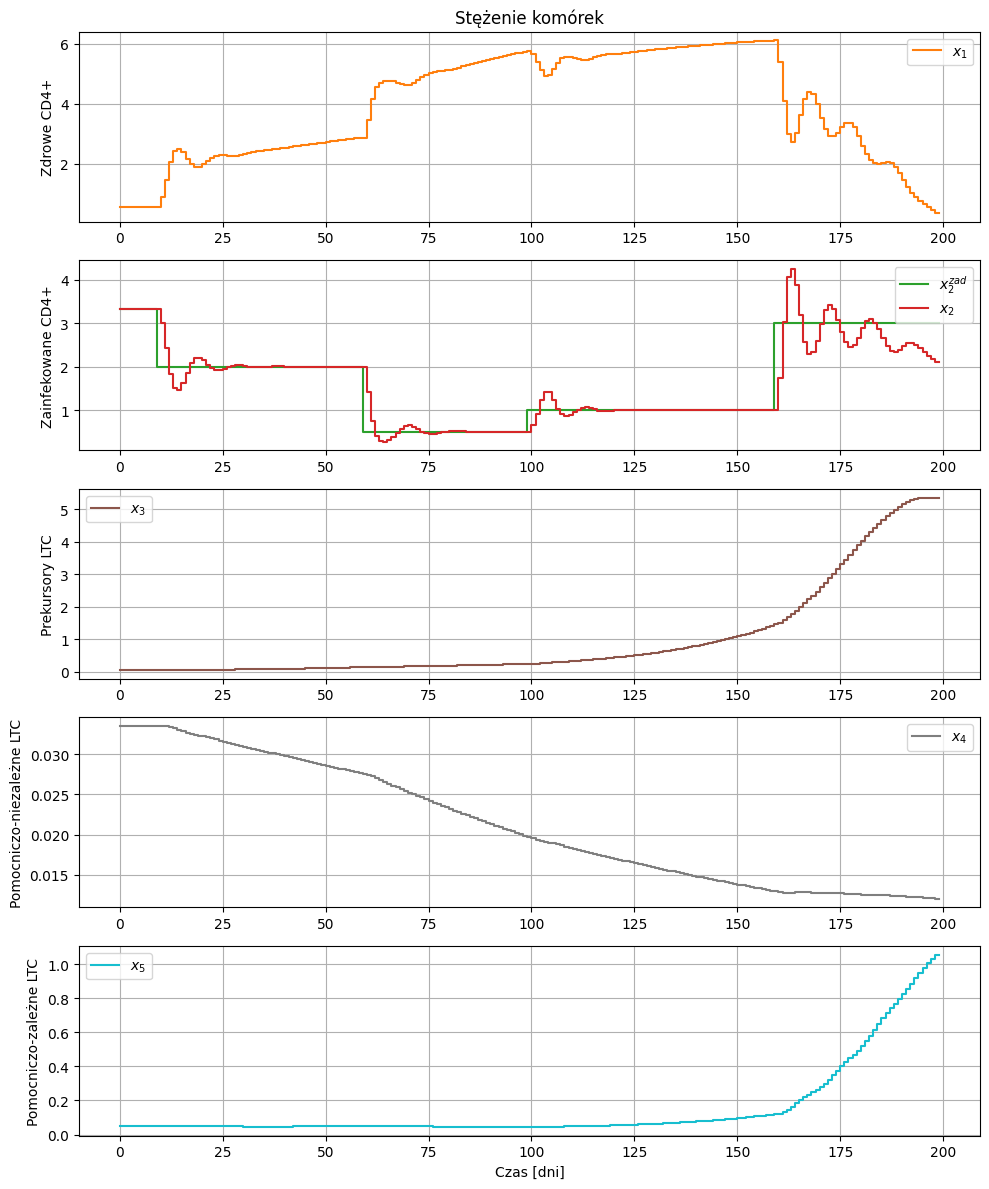

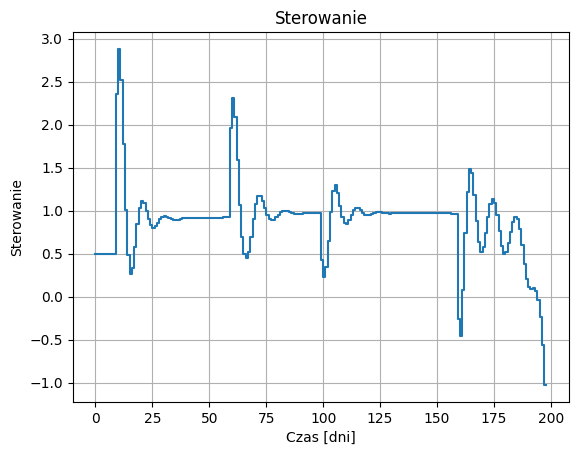

In [22]:
plot(y_zad, x, u, w, save=False)